# Training
**GOAL**: Train the classification model with the best hyperparameters found on the full training dataset

In [4]:
import sys
import os
import import_ipynb

# Add the folder containing "files.ipynb" to the Python path
sys.path.append(os.path.abspath("Utils"))
# Import the files notebook
import Utils.file_manager as fm

import numpy as np
import pandas as pd

SEED = 48
DIM_PRE_EMBEDDING = 200
ARRAY_DIRECTORY_PATH = "./Array_After_Preprocessing"

### Dataset '**Train**'

In [3]:
df = pd.read_csv("./Datasets/train.csv")

In [4]:
df.describe()

,id,polarity,text,source
count,8082,8082,8082,8082
unique,8082,3,8030,2
top,t1,neutral,"Excellent, thanks!",github
freq,1,3301,7,4985


In [5]:
df.source.value_counts()

source
github           4985
stackoverflow    3097
Name: count, dtype: int64

In [6]:
df.head()

,id,polarity,text,source
0,t1,negative,"Vineet, what you are trying to do is a terribl...",stackoverflow
1,t2,positive,"'Course I do, corrected.",stackoverflow
2,t3,positive,"Excellent, happy to help! If you don't mind, c...",stackoverflow
3,t6,negative,@talnicolas I'm using it a few dozen times in ...,stackoverflow
4,t7,neutral,I didn't select an answer because even though ...,stackoverflow


### Dataset '**Test_public**'

In [7]:
df_test_public = pd.read_csv("./Datasets/test_public.csv")

In [8]:
df_test_public.describe()

,id,text,source
count,3463,3463,3463
unique,3463,3454,2
top,t4,what about 3rd question?( When is it appropria...,github
freq,1,2,2137


In [9]:
df_test_public.source.value_counts()

source
github           2137
stackoverflow    1326
Name: count, dtype: int64

In [10]:
df_test_public.head()

,id,text,source
0,t4,@DrabJay: excellent suggestion! Code changed. :-),stackoverflow
1,t5,Any decent browser should protect against mali...,stackoverflow
2,t8,I swear - I don't put pseudo code I get told o...,stackoverflow
3,t9,I have attached below,stackoverflow
4,t13,When I refactor the following line: using Resh...,stackoverflow


## Preprocessing 1
### Dataset '**train**'

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
y1 = LabelEncoder().fit_transform(df.polarity)

## Preprocessing 2 - extract EMBEDDINGs

In [13]:
import spacy

In [14]:
# 1. Initialize a blank pipeline
nlp = spacy.blank("en")

### Import embeddings Model from disk

In [15]:
tok2vec = nlp.add_pipe("tok2vec", config={'model': {'width': DIM_PRE_EMBEDDING}})
tok2vec.from_disk("./Embedding_model_trained")

### Dataset '**train**'
#### Get embedding for 'text' column

In [ ]:
X_embedded = fm.import_array("X_embedded", ARRAY_DIRECTORY_PATH)

### Dataset '**test_public**'
#### Get embedding for 'text' column

In [ ]:
X_TP_embedded = fm.import_array("X_TP_embedded", ARRAY_DIRECTORY_PATH)

## Preprocessing 3 - extract NEW FEATUREs

### Dataset '**train**'
#### Get new features from 'text' column

In [ ]:
X_new_features = fm.import_array("X_new_features", ARRAY_DIRECTORY_PATH)

### Dataset '**test_public**'
#### Get new features from 'text' column

In [ ]:
X_TP_new_feature = fm.import_array("X_TP_new_feature", ARRAY_DIRECTORY_PATH)

## Preprocessing 4 - extract BIGRAMs

### Dataset '**train**'
#### Get the most frequent bigrams from 'text' column

In [ ]:
X_bigram = fm.import_array("X_bigram", ARRAY_DIRECTORY_PATH)

In [21]:
# Merge of all the columns after the transormations
X1 = np.concatenate([X_embedded, X_new_features, X_bigram], axis=1)

### Dataset '**test_public**'
#### Get the most frequent bigrams from 'text' column

In [ ]:
X_TF_bigram = fm.import_array("X_TF_bigram", ARRAY_DIRECTORY_PATH)

In [23]:
# Merge of all the columns after the transormations
X_TP = np.concatenate([X_TP_embedded, X_TP_new_feature, X_TF_bigram], axis=1)

## Training

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics

Set the best hyperparameters found in TrainClassifiers module

In [27]:
cls = GradientBoostingClassifier(n_estimators=70, 
                                subsample=0.8, 
                                min_samples_leaf=20,
                                max_depth=15,
                                random_state=SEED,
                                verbose=True
                                )

###  ALLERT!!!!!!!!!!!!!!!!

In [28]:
cls.fit(X1, y1)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9647           0.0887            4.97m
         2           0.8702           0.0902            5.06m
         3           0.7922           0.0833            5.00m
         4           0.7262           0.0671            5.00m
         5           0.6702           0.0643            4.98m
         6           0.6166           0.0423            4.93m
         7           0.5746           0.0551            4.91m
         8           0.5335           0.0399            4.84m
         9           0.4967           0.0358            4.77m
        10           0.4620           0.0295            4.72m
        20           0.2497           0.0112            4.01m
        30           0.1426           0.0089            3.28m
        40           0.0823           0.0002            2.49m
        50           0.0488           0.0005            1.68m
        60           0.0295           0.0022           50.51s
       

GradientBoostingClassifier(max_depth=15, min_samples_leaf=20, n_estimators=70,
                           random_state=48, subsample=0.8, verbose=True)

------------END

### Score on train set

In [32]:
X_y_pred = cls.predict(X1)
metrics.f1_score(y_true=y1, y_pred=X_y_pred, average='macro')

0.9997542817522763

### Prediction on test dataset 

In [34]:
y_test_public = cls.predict(X_TP)

### Make the test public dataset presentable

In [35]:
# Attach the id
col1 = np.asarray(df_test_public.loc[:, ["id"]])
col2 = np.reshape(y_test_public, (3463, 1))

y_submission = np.concatenate( (col1, col2), axis=1)

In [36]:
y_submission = pd.DataFrame(y_submission)
y_submission.columns = ['id', 'polarity']
y_submission.loc[:, "polarity"].value_counts()

polarity
1    1522
2    1081
0     860
Name: count, dtype: int64

In [37]:
y_submission.to_csv('./Submission/Last_Submit.csv', index=False)

# Compare the official labels with mine

In [30]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
official = pd.read_csv("./Datasets/test.csv")
mine = pd.read_csv("./Submission/Last_Submit.csv")

In [10]:
official.head()

,id,polarity,text,source
0,t4,positive,@DrabJay: excellent suggestion! Code changed. :-),stackoverflow
1,t5,neutral,Any decent browser should protect against mali...,stackoverflow
2,t8,negative,I swear - I don't put pseudo code I get told o...,stackoverflow
3,t9,neutral,I have attached below,stackoverflow
4,t13,negative,When I refactor the following line: using Resh...,stackoverflow


In [17]:
mine.polarity = mine.polarity.map({0: "negative", 1:"neutral", 2:"positive"})

In [18]:
mine.head()

,id,polarity
0,t4,positive
1,t5,positive
2,t8,negative
3,t9,neutral
4,t13,negative


In [44]:
conf_matrix = metrics.confusion_matrix(official.polarity, mine.polarity)

In [45]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["negative", "neutral", "positive"])

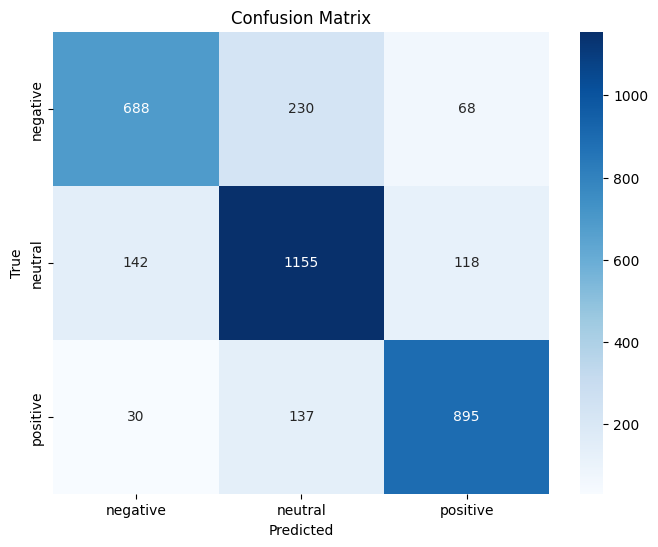

In [52]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"], fmt='d', cmap='Blues')  # Change 'Blues' to other colormap like 'coolwarm', 'viridis', etc.
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Official scores

In [24]:
y_official = official.polarity.map({"negative":0, "neutral":1, "positive":2})
y_mine = mine.polarity.map({"negative":0, "neutral":1, "positive":2})

### F1

In [25]:
metrics.f1_score(y_true=y_official, y_pred=y_mine, average='macro')

0.7890633172367253

### Precision

In [26]:
metrics.precision_score(y_true=y_official, y_pred=y_mine,average='macro')

0.7956023344326383

### Recall

In [27]:
metrics.recall_score(y_true=y_official, y_pred=y_mine,average='macro')

0.7855909029429409